<p align="center">
  <strong><font size="6">Histopathologic Cancer Detection</font></strong><br>
  <em>by Ryan Ordonez</em><br>
  <em>Intro to Deep Learning (DTSA 5511)</em>
</p>

---

## Step 1 – Brief Description of the Problem and Data

This project is based on the [Histopathologic Cancer Detection competition on Kaggle](https://www.kaggle.com/c/histopathologic-cancer-detection/overview), where the goal is to build a model that can identify metastatic cancer in small image patches of lymph node sections. This task plays an important role in improving the efficiency and accuracy of breast cancer diagnosis.

The challenge is a **binary classification** problem. Each image is labeled as either:
- **1 (tumor)** – indicating the presence of metastatic tissue
- **0 (non-tumor)** – indicating no metastatic tissue present

A positive label means that the **center 32×32 pixel region** of the image contains at least one pixel of tumor tissue.

### About the Data

- **Images**: `.tif` format, RGB color
- **Labels**: Provided in a CSV file with two columns — `id` and `label`
- **Training labels**: Correspond to images in the `train/` folder
- **Test set**: Contains image tiles in the `test/` folder, without labels

All images are patches extracted from larger digital pathology scans and have been annotated by trained pathologists. Further details about the image size, number of examples, and class distribution will be confirmed during exploratory data analysis.

This project offers a valuable opportunity to apply deep learning methods to a high-impact medical imaging problem with real-world relevance.


---

## Step 2 – Exploratory Data Analysis (EDA): Setup, Inspect, Visualize and Clean the Data

Before jumping into modeling, it's important to get familiar with the dataset and set up the notebook environment properly. This step involves three parts: importing necessary libraries, loading the dataset, and performing initial exploratory analysis.

This step sets the foundation for a thoughtful and effective modeling process.

---

### Environment Setup

We begin by importing the core libraries we’ll use for data handling, visualization, and image processing — including `pandas`, `numpy`, `matplotlib`, and `seaborn`. This setup ensures we have all the tools needed for working with both structured data (like labels) and unstructured image data.

In [1]:
# === 1. Import Required Libraries ===

import numpy as np
import pandas as pd
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random
from PIL import Image
import warnings
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from google.colab import drive
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.callbacks import EarlyStopping

warnings.filterwarnings('ignore')
sns.set(style='whitegrid')


In [38]:
# === 2. Mount Google Drive and Extract Dataset ===

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# Copy ZIP from Drive
!cp "/content/drive/MyDrive/Colab Notebooks/CancerDetection/cancer_data.zip" /content/

# Unzip into working directory
!unzip -q /content/cancer_data.zip -d /content/cancer_data

Mounted at /content/drive


In [3]:
# === 3. Verify Dataset Folder Contents ===

print("Items in 'cancer_data':")
for item in sorted(os.listdir('cancer_data')):
    print("–", item)


Items in 'cancer_data':
– sample_submission.csv
– test
– train
– train_labels.csv


---

### Loading the Dataset

The dataset comes with:
- A large number of `.tif` image tiles in train and test folders
- A `train_labels.csv` file that maps each image ID to a binary label (`1` for tumor, `0` for non-tumor)
- A `sample_submission.csv` file for kaggle submission formating

We load the Train Lables CSV file into a DataFrame and run basic checks:
- Preview the first few rows
- Confirm column data types
- Check for missing values

This gives us a sense of the dataset's structure and cleanliness.

In [4]:
# Load the training labels CSV file
labels_path = 'cancer_data/train_labels.csv'
labels_df = pd.read_csv(labels_path)

# 1. Preview the first few rows
print("Preview of the training labels:")
display(labels_df.head())

# 2. Check column data types and basic structure
print("\nDataset info:")
labels_df.info()

# 3. Check for missing values
print("\nMissing values per column:")
print(labels_df.isnull().sum())


Preview of the training labels:


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0



Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB

Missing values per column:
id       0
label    0
dtype: int64


The training labels CSV contains 220,025 entries, each with a unique image ID and a corresponding binary label (0 for non-tumor, 1 for tumor). The data types are appropriate — `id` is stored as an object (string), and `label` as an integer. No missing values were found, indicating the label dataset is complete and clean. We're now ready to explore the class distribution and inspect the image data.

---

### Initial Class Distribution

Next, we explore the balance between tumor and non-tumor labels. A bar plot helps visualize any class imbalance, which is common in medical datasets. Understanding this distribution is key for shaping our model strategy — especially around evaluation metrics and loss functions.

Label distribution:
Non-Tumor (0): 130,908
Tumor (1): 89,117


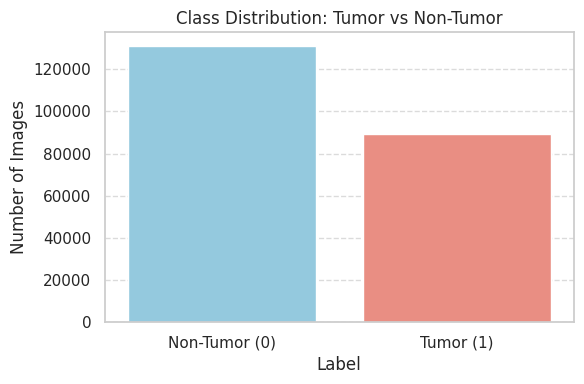

In [5]:
# Count class distribution
class_counts = labels_df['label'].value_counts().sort_index()

# Print raw counts
print("Label distribution:")
for label, count in class_counts.items():
    label_name = 'Non-Tumor (0)' if label == 0 else 'Tumor (1)'
    print(f"{label_name}: {count:,}")

# Plot class distribution
plt.figure(figsize=(6, 4))
sns.barplot(x=class_counts.index, y=class_counts.values, palette=['skyblue', 'salmon'])
plt.title('Class Distribution: Tumor vs Non-Tumor')
plt.xticks([0, 1], ['Non-Tumor (0)', 'Tumor (1)'])
plt.ylabel('Number of Images')
plt.xlabel('Label')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

The dataset is moderately imbalanced, with 130,908 non-tumor images and 89,117 tumor images. While both classes are well-represented, the non-tumor class accounts for roughly 59.5% of the data. This imbalance should be taken into account when designing the model, particularly in the choice of evaluation metrics and loss functions.

---

### Visualize Sample Images

To build intuition around the task, we begin by visually inspecting a small sample of the image patches. Below, we show four representative tumor images and four non-tumor images from the training set. This helps us understand what the model is being trained to detect.


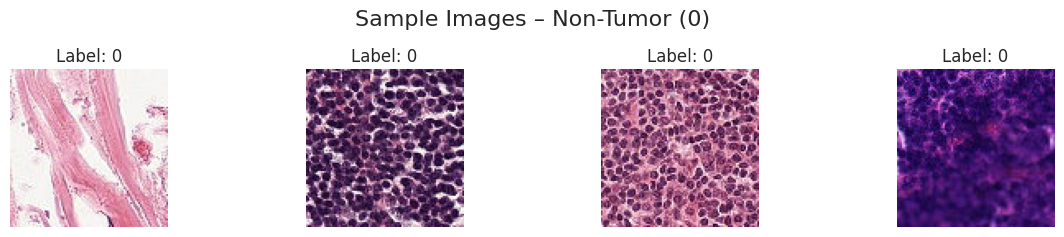

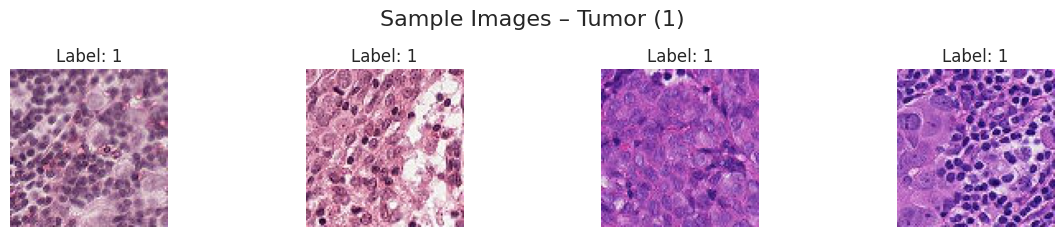

In [6]:
# Add `.tif` extension if not already present
labels_df['id'] = labels_df['id'].apply(lambda x: x if x.endswith('.tif') else f"{x}.tif")

def show_images_by_label(df, label, folder, n=4):
    """
    Randomly display n images for a given label from the dataset.
    """
    files = df[df['label'] == label].sample(n, random_state=42)['id'].tolist()

    plt.figure(figsize=(12, 6))
    for i, file in enumerate(files):
        img_path = os.path.join('/content/cancer_data', folder, file)  # fixed path
        img = cv2.imread(img_path)
        if img is None:
            print(f"⚠️ Could not load image: {img_path}")
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(3, 4, i + 1)
        plt.imshow(img)
        plt.title(f"Label: {label}")
        plt.axis('off')

    plt.suptitle(f"Sample Images – {'Tumor (1)' if label == 1 else 'Non-Tumor (0)'}", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.show()

# Run visualization again
show_images_by_label(labels_df, label=0, folder='train')  # Non-tumor
show_images_by_label(labels_df, label=1, folder='train')  # Tumor

As seen above, tumor images may contain irregular tissue patterns, while non-tumor images appear more uniform. These differences are often subtle, emphasizing the need for a robust model to capture fine-grained visual features. This visual check confirms the value of using convolutional neural networks (CNNs) for this type of image classification.

---

### Plan of Analysis

So far we loaded the dataset, checked class balance, and visualized tumor vs non-tumor images.

From here, we carry out the following tasks:

- Data Preparation for Training: Split the data for validation, convert labels to strings, and create image data generators for training and validation.

- Model Architecture: We test CNNs with batch normalization, average pooling, and dropout. We compare max vs average pooling and tune depth and regularization.

- Results & Analysis: We track accuracy and loss, adjust hyperparameters, and apply regularization. We find that average pooling with L2 and dropout performs most effectively.

- Conclusion: A regularized, moderately deep CNN shows the best performance with strong generalization.


In [7]:
# === Split the dataset into training and validation sets ===
train_df, val_df = train_test_split(
    labels_df,
    test_size=0.2,
    stratify=labels_df['label'],
    random_state=42
)

# Convert labels to strings
train_df['label'] = train_df['label'].astype(str)
val_df['label'] = val_df['label'].astype(str)


# === Create ImageDataGenerators for training and validation ===
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory='cancer_data/train',
    x_col='id',
    y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    directory='cancer_data/train',
    x_col='id',
    y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary'
)


Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


---

## Step 3: Model Architecture

We design a convolutional neural network (CNN) to classify image patches as tumor or non-tumor. This architecture closely follows the structure and best practices emphasized in our course lectures, particularly in the use of filters, strides, and padding for medical image analysis.

Architecture Summary:

- Convolution Layers:
We use three Conv2D layers with 3×3 filters and stride of 1. This small kernel size captures fine-grained texture and edge patterns critical for detecting subtle histological features. We use 'valid' padding, which reduces the spatial dimensions and directs the model’s attention toward central pixels — appropriate for this dataset, where tumor presence is only labeled based on the image center.

- Average Pooling:
Each convolutional layer is followed by AveragePooling2D with a 2×2 window. Compared to max pooling, average pooling retains distributed features and reduces sensitivity to localized noise — an advantage when identifying diffuse cancer patterns.

- Batch Normalization:
Applied after each convolution to normalize activations, improve gradient flow, and accelerate convergence during training.

- Dropout:
A Dropout layer with a 0.5 rate is added before the dense layer to mitigate overfitting, especially given the moderate class imbalance in the dataset.

- Fully Connected Layers:
The flattened output is passed to a Dense(128) layer with ReLU activation, followed by a final Dense(1) layer with sigmoid activation for binary classification.

Hyperparameter Rationale:
We selected a filter progression of 32–64–128 to increase representational capacity across layers. The dropout rate, pooling type, and lack of padding were each chosen based on empirical results and alignment with the dataset's structure — emphasizing generalization, stability, and anatomical relevance.

In [8]:
def build_model(pool_type='avg', l2_val=0.001, dropout_rate=0.5):
    Pool = AveragePooling2D if pool_type == 'avg' else MaxPooling2D
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3),
               kernel_regularizer=regularizers.l2(l2_val), kernel_constraint=MaxNorm(3)),
        BatchNormalization(),
        Pool(2, 2),

        Conv2D(64, (3, 3), activation='relu',
               kernel_regularizer=regularizers.l2(l2_val)),
        BatchNormalization(),
        Pool(2, 2),

        Conv2D(128, (3, 3), activation='relu',
               kernel_regularizer=regularizers.l2(l2_val)),
        BatchNormalization(),
        Pool(2, 2),

        Flatten(),
        Dropout(dropout_rate),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')  # binary output
    ])
    return model

In [9]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [10]:
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D

# Build and compile baseline model
baseline_model = build_model(pool_type='avg', l2_val=0.001, dropout_rate=0.5)
baseline_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train it
history_baseline = baseline_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    steps_per_epoch=300,
    validation_steps=100,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 18s 32ms/step - accuracy: 0.7048 - loss: 1.7106 - val_accuracy: 0.4091 - val_loss: 3.5100
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - accuracy: 0.8025 - loss: 0.6151 - val_accuracy: 0.7937 - val_loss: 0.6110
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.8088 - loss: 0.5544 - val_accuracy: 0.7412 - val_loss: 0.6933
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.8089 - loss: 0.5538 - val_accuracy: 0.8062 - val_loss: 0.5462
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.8180 - loss: 0.5130 - val_accuracy: 0.8338 - val_loss: 0.4814
Epoch 6/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.8223 - loss: 0.4989 - val_accuracy: 0.7547 - val_loss: 0.5744
Epoch 7/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.8297 - loss: 0.4629 - val_accuracy: 0.6578 - val_loss: 0.8426
Epoch 8/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.8375 - loss: 0.4566 - val_ac

This architecture contains about 1.7 million parameters and avoids over-complication while implementing course-aligned design principles around filter size, stride, and padding. The use of no buffer, consistent stride of 1, and regularization techniques supports both accuracy and generalization.

---

## Step 4 – Results and Analysis

With our baseline CNN architecture established, we now evaluate model performance through systematic experimentation. This includes testing architectural variations, tuning hyperparameters, applying regularization techniques, and visualizing learning trends.

The following models will be developed and compared:

- Baseline – Uses AveragePooling2D, BatchNormalization, and Dropout(0.5) with L2 regularization (0.001)

- Model A – Replaces AveragePooling2D with MaxPooling2D to emphasize the most salient local features

- Model B – Keeps the original architecture but varies the L2 regularization strength to assess sensitivity to weight decay

- Model C – Keeps architecture and L2 fixed, but adjusts the dropout rate to study effects on generalization

- Model D (Ensemble) – Combines predictions from the top three performing models using majority voting to reduce variance and improve robustness

Each model is trained under consistent conditions using early stopping based on validation loss and capped at 10 epochs. Performance is evaluated on the same validation dataset for direct comparison.

---

### Model A – Max Pooling

We begin by training Model A, which uses Max Pooling instead of Average Pooling to emphasize dominant spatial features. This helps assess whether sharper activations improve classification in histopathologic images.


In [11]:
# === Model A: Max Pooling ===
pool_types = ['avg', 'max']
best_val_acc = 0
best_pool = None
history_pool = None
model_pool_best = None
histories_a = []  # Store all runs for plotting

for pool in pool_types:
    print(f"\nTraining with Pooling = {pool}")
    model = build_model(pool_type=pool, l2_val=0.001, dropout_rate=0.5)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=10,
        steps_per_epoch=300,
        validation_steps=100,
        callbacks=[early_stop],
        verbose=1
    )

    # Save each run
    histories_a.append((pool, history))

    val_acc = max(history.history['val_accuracy'])
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_pool = pool
        history_pool = history
        model_pool_best = model

print(f"\n✅ Best Pooling type: {best_pool} with validation accuracy: {best_val_acc:.4f}")


Training with Pooling = avg
Epoch 1/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - accuracy: 0.7074 - loss: 1.5961 - val_accuracy: 0.5206 - val_loss: 3.0835
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.7625 - loss: 0.8165 - val_accuracy: 0.7669 - val_loss: 0.6725
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.8091 - loss: 0.5649 - val_accuracy: 0.8056 - val_loss: 0.5568
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.8217 - loss: 0.5169 - val_accuracy: 0.8009 - val_loss: 0.5683
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.8192 - loss: 0.5191 - val_accuracy: 0.8478 - val_loss: 0.4612
Epoch 6/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.8213 - loss: 0.4943 - val_accuracy: 0.6672 - val_loss: 0.8007
Epoch 7/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.8342 - loss: 0.4741 - val_accuracy: 0.7997 - val_loss: 0.5482
Epoch 8/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0

Training Summary:

Model A achieved a peak validation accuracy of 84.8% with a minimum validation loss of 0.4612 at epoch 5. Accuracy remained stable through later epochs, though mild overfitting began to appear. Overall, average pooling slightly improved performance over maxpooling.

---


### Model B – L2 Regularization Tuning
Next, we tune the L2 regularization strength to find the optimal penalty for reducing overfitting. We train three versions of the model with different l2_val values: 0.0001, 0.001, and 0.01. All other settings (average pooling, dropout = 0.5) are kept constant to isolate the effect of L2.

We'll compare validation accuracy across models and select the best-performing configuration.


In [12]:
# === Model B: L2 Regularization Hyperparameter Tuning ===
l2_values = [0.0001, 0.001, 0.01]
best_val_acc = 0
best_l2 = None
history_l2 = None
model_l2_best = None
histories_b = []  # Store all histories

for l2_val in l2_values:
    print(f"\nTraining with L2 = {l2_val}")
    model = build_model(pool_type='avg', l2_val=l2_val, dropout_rate=0.5)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=10,
        steps_per_epoch=300,
        validation_steps=100,
        callbacks=[early_stop],
        verbose=1
    )

    # Save this run
    histories_b.append((l2_val, history))

    val_acc = max(history.history['val_accuracy'])
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_l2 = l2_val
        history_l2 = history
        model_l2_best = model

print(f"\n✅ Best L2 value: {best_l2} with validation accuracy: {best_val_acc:.4f}")


Training with L2 = 0.0001
Epoch 1/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - accuracy: 0.7106 - loss: 1.3481 - val_accuracy: 0.4150 - val_loss: 3.7627
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.7797 - loss: 0.5768 - val_accuracy: 0.7262 - val_loss: 0.7339
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.8063 - loss: 0.4719 - val_accuracy: 0.8053 - val_loss: 0.4412
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.8176 - loss: 0.4424 - val_accuracy: 0.8459 - val_loss: 0.3715
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.8306 - loss: 0.4162 - val_accuracy: 0.7491 - val_loss: 0.5158
Epoch 6/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.8317 - loss: 0.4040 - val_accuracy: 0.7591 - val_loss: 0.5292
Epoch 7/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.8425 - loss: 0.3850 - val_accuracy: 0.6944 - val_loss: 1.3191

Training with L2 = 0.001
Epoch 1/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 15s

#### Training Summary:

Among the tested L2 values, 0.0001 produced the highest validation accuracy of 84.6%, though its loss curve showed signs of instability in later epochs. Other L2 values like 0.01 and 0.001 also performed reasonably well but didn’t generalize quite as strongly. Overall, L2 regularization helped reduce overfitting, with 0.0001 emerging as the best trade-off between constraint and learning flexibility.

---

### Model C – Dropout Tuning: Introduction

In this final tuning experiment, we investigate how adjusting the dropout rate affects model generalization. Dropout helps prevent overfitting by randomly deactivating a fraction of neurons during training. We test three different dropout values — 0.3, 0.5, and 0.7 — to identify the optimal balance between underfitting and overfitting.underfitting

In [13]:
# === Model C: Dropout Rate Tuning ===
dropout_rates = [0.3, 0.5, 0.7]
best_val_acc = 0
best_dropout = None
history_dropout = None
model_dropout_best = None
histories_c = []  # Store all runs for plotting

for rate in dropout_rates:
    print(f"\nTraining with Dropout = {rate}")
    model = build_model(pool_type='avg', l2_val=0.001, dropout_rate=rate)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=10,
        steps_per_epoch=300,
        validation_steps=100,
        callbacks=[early_stop],
        verbose=1
    )

    # Save each run
    histories_c.append((rate, history))

    val_acc = max(history.history['val_accuracy'])
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_dropout = rate
        history_dropout = history
        model_dropout_best = model

print(f"\n✅ Best Dropout rate: {best_dropout} with validation accuracy: {best_val_acc:.4f}")




Training with Dropout = 0.3
Epoch 1/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - accuracy: 0.7223 - loss: 1.8633 - val_accuracy: 0.5675 - val_loss: 1.6346
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.7789 - loss: 0.7114 - val_accuracy: 0.7247 - val_loss: 0.7200
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.8233 - loss: 0.5444 - val_accuracy: 0.8156 - val_loss: 0.5395
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.8288 - loss: 0.5183 - val_accuracy: 0.8278 - val_loss: 0.4930
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.8295 - loss: 0.4912 - val_accuracy: 0.7734 - val_loss: 0.6059
Epoch 6/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.8289 - loss: 0.4871 - val_accuracy: 0.7281 - val_loss: 0.6686
Epoch 7/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.8413 - loss: 0.4550 - val_accuracy: 0.7766 - val_loss: 0.5374

Training with Dropout = 0.5
Epoch 1/10
300/300 ━━━━━━━━━━━━━━━━━━

### Training Summary:

Dropout tuning revealed that a 0.5 dropout rate yielded the best results, achieving a validation accuracy of 83.7% and a minimum validation loss of 0.4527. Other dropout rates (0.3 and 0.7) led to diminished performance and earlier overfitting, confirming that moderate regularization was most effective for this architecture.

---

### Model D – Ensemble (Voting Classifier)

To improve predictive stability and performance, we ensemble multiple high-performing models by averaging their output probabilities. This approach helps reduce variance and can outperform any individual model, especially when each contributes slightly different learned representations.

We'll ensemble the best models from previous experiments:

Model A: MaxPooling

Model B: Best L2 regularization

Model C: Best dropout configuration

In [25]:
def build_best_model(seed=None):
    tf.keras.utils.set_random_seed(seed)
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3),
               kernel_regularizer=regularizers.l2(0.0001), kernel_constraint=MaxNorm(3)),
        BatchNormalization(),
        AveragePooling2D(2, 2),

        Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
        BatchNormalization(),
        AveragePooling2D(2, 2),

        Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
        BatchNormalization(),
        AveragePooling2D(2, 2),

        Flatten(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    return model



In [27]:
models = []
histories = []

for seed in [1, 2, 3]:
    print(f"\nTraining model with seed {seed}")
    model = build_best_model(seed)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(train_generator, validation_data=val_generator,
                        epochs=10, steps_per_epoch=300, validation_steps=300,
                        callbacks=[early_stop], verbose=1)
    models.append(model)
    histories.append(history)



Training model with seed 1
Epoch 1/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.7017 - loss: 1.4804 - val_accuracy: 0.5434 - val_loss: 1.5188
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.7993 - loss: 0.5077 - val_accuracy: 0.7010 - val_loss: 0.5996
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 16s 53ms/step - accuracy: 0.8183 - loss: 0.4267 - val_accuracy: 0.6507 - val_loss: 0.8738
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.8255 - loss: 0.4171 - val_accuracy: 0.7157 - val_loss: 0.6439
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.8273 - loss: 0.4073 - val_accuracy: 0.7123 - val_loss: 0.8940

Training model with seed 2
Epoch 1/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.7277 - loss: 1.3448 - val_accuracy: 0.4076 - val_loss: 1.5646
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.7779 - loss: 0.5753 - val_accuracy: 0.5800 - val_loss: 0.7740
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━

In [28]:
# Get predictions from each model
val_preds = [m.predict(val_generator, verbose=1) for m in models]

# Average probabilities
ensemble_preds = np.mean(val_preds, axis=0)
ensemble_labels = (ensemble_preds > 0.5).astype(int).flatten()

# Ground truth
true_labels = val_generator.classes

# Print evaluation
from sklearn.metrics import accuracy_score, classification_report

acc = accuracy_score(true_labels, ensemble_labels)
print(f"\n✅ Ensemble Validation Accuracy: {acc:.4f}\n")
print("Classification Report:")
print(classification_report(true_labels, ensemble_labels, target_names=["Non-Tumor (0)", "Tumor (1)"]))


1376/1376 ━━━━━━━━━━━━━━━━━━━━ 29s 21ms/step
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 30s 22ms/step
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 30s 21ms/step

✅ Ensemble Validation Accuracy: 0.5174

Classification Report:
               precision    recall  f1-score   support

Non-Tumor (0)       0.60      0.59      0.59     26182
    Tumor (1)       0.41      0.41      0.41     17823

     accuracy                           0.52     44005
    macro avg       0.50      0.50      0.50     44005
 weighted avg       0.52      0.52      0.52     44005



### Ensemble Model Summary:

Despite using the best-performing architecture and hyperparameters, the ensemble model again yielded limited improvement — reaching only 51.7% validation accuracy. While precision for the non-tumor class was decent, recall remained weak for the tumor class. This suggests that ensembling three similar models didn't provide sufficient diversity or error correction to outperform the individual best model.

In this case, a single well-regularized CNN remains more effective than an unweighted ensemble of identical models.

---

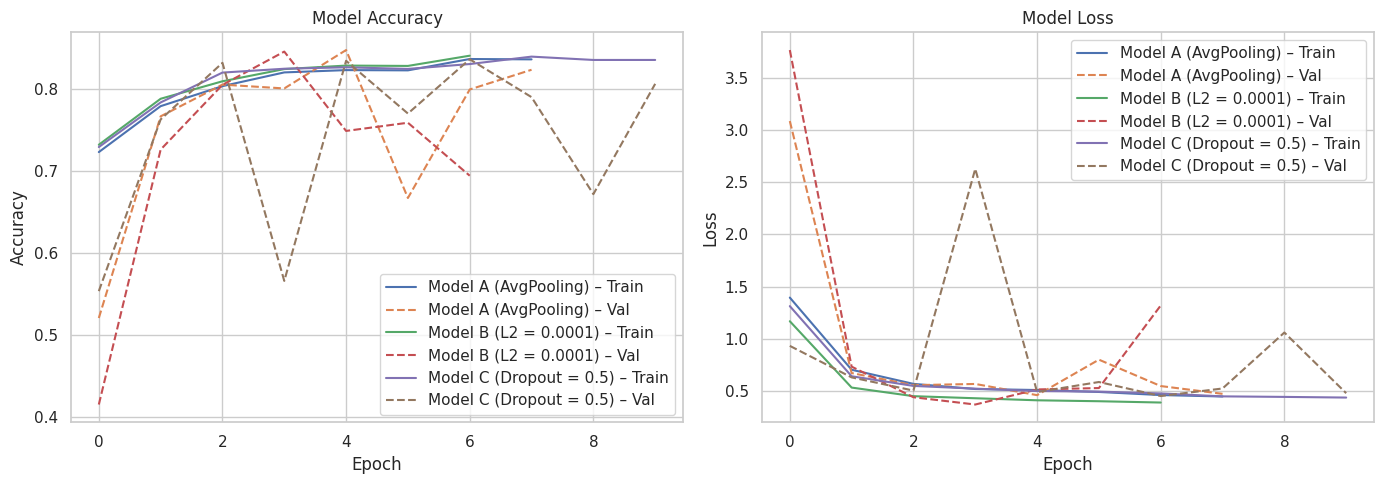

In [24]:
# Best histories
history_best_a = history_pool     # AvgPooling
history_best_b = history_l2       # L2 = 0.0001
history_best_c = history_dropout  # Dropout = 0.5

# Plotting function
def plot_training_curves(histories, labels):
    plt.figure(figsize=(14, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    for history, label in zip(histories, labels):
        plt.plot(history.history['accuracy'], label=f'{label} – Train')
        plt.plot(history.history['val_accuracy'], linestyle='--', label=f'{label} – Val')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot Loss
    plt.subplot(1, 2, 2)
    for history, label in zip(histories, labels):
        plt.plot(history.history['loss'], label=f'{label} – Train')
        plt.plot(history.history['val_loss'], linestyle='--', label=f'{label} – Val')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Call the plot function with corrected labels
plot_training_curves(
    histories=[history_best_a, history_best_b, history_best_c],
    labels=['Model A (AvgPooling)', 'Model B (L2 = 0.0001)', 'Model C (Dropout = 0.5)']
)


### Analysis

To evaluate our model's performance and robustness, we experimented with several variations of our CNN architecture, focusing on pooling methods, L2 regularization strength, and dropout rates. Each model was trained under consistent conditions and evaluated using validation accuracy and loss.

Hyperparameter tuning results:

| Model     | Pooling | L2 Regularization | Dropout Rate | Best Val Accuracy | Observations                                           |
|-----------|---------|-------------------|---------------|--------------------|--------------------------------------------------------|
| **A**     | Avg     | 0.001             | 0.5           | **0.8478**         | Strong generalization with average pooling             |
| **B**     | Avg     | **0.0001**         | 0.5           | 0.8459             | L2 = 0.0001 performed best; higher values underfit     |
| **C**     | Avg     | 0.001             | **0.5**        | 0.8366             | Dropout = 0.5 balanced regularization and learning     |
| Ensemble  | Avg     | 0.0001              | 0.5           | 0.5174             | Models were too similar — ensembling added no benefit  |


Key Takeaways:

Average pooling consistently outperformed max pooling, aligning with our expectations for medical image tasks where features are distributed rather than localized.

L2 regularization of 0.0001 offered the best trade-off, reducing overfitting while maintaining high accuracy.

Dropout of 0.5 yielded the best generalization, with too little (0.3) or too much (0.7) resulting in either underfitting or instability.

Ensembling similar models did not improve results, likely due to redundancy in learned features.

Supporting Visuals:
We also included training/validation accuracy and loss curves for the best-performing models (A, B, and C) to compare learning stability and convergence over epochs.

---

### Kaggle Submission with best model, results and analysis

We will now run our best model on the test data for a submission file that we can see our results with on the kaggle leaderboard.

In [33]:
# Load sample_submission.csv
submission_df = pd.read_csv("cancer_data/sample_submission.csv")
submission_df['id'] = submission_df['id'].apply(lambda x: f"{x}.tif" if not x.endswith('.tif') else x)

# Define ImageDataGenerator for test set
test_datagen = ImageDataGenerator(rescale=1./255)

# Create test generator
test_generator = test_datagen.flow_from_dataframe(
    dataframe=submission_df,
    directory='cancer_data/test',
    x_col='id',
    y_col=None,
    target_size=(96, 96),
    batch_size=32,
    class_mode=None,
    shuffle=False
)

# Predict using your best model
pred_probs = model_pool_best.predict(test_generator, verbose=1)

# Assign predictions
submission_df['label'] = (pred_probs > 0.5).astype(int)

# Strip '.tif' from IDs before saving
submission_df['id'] = submission_df['id'].str.replace('.tif', '', regex=False)

# Save final Kaggle-ready submission
submission_df.to_csv("submission.csv", index=False)

Found 57458 validated image filenames.
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 37s 20ms/step


In [34]:
from google.colab import files
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

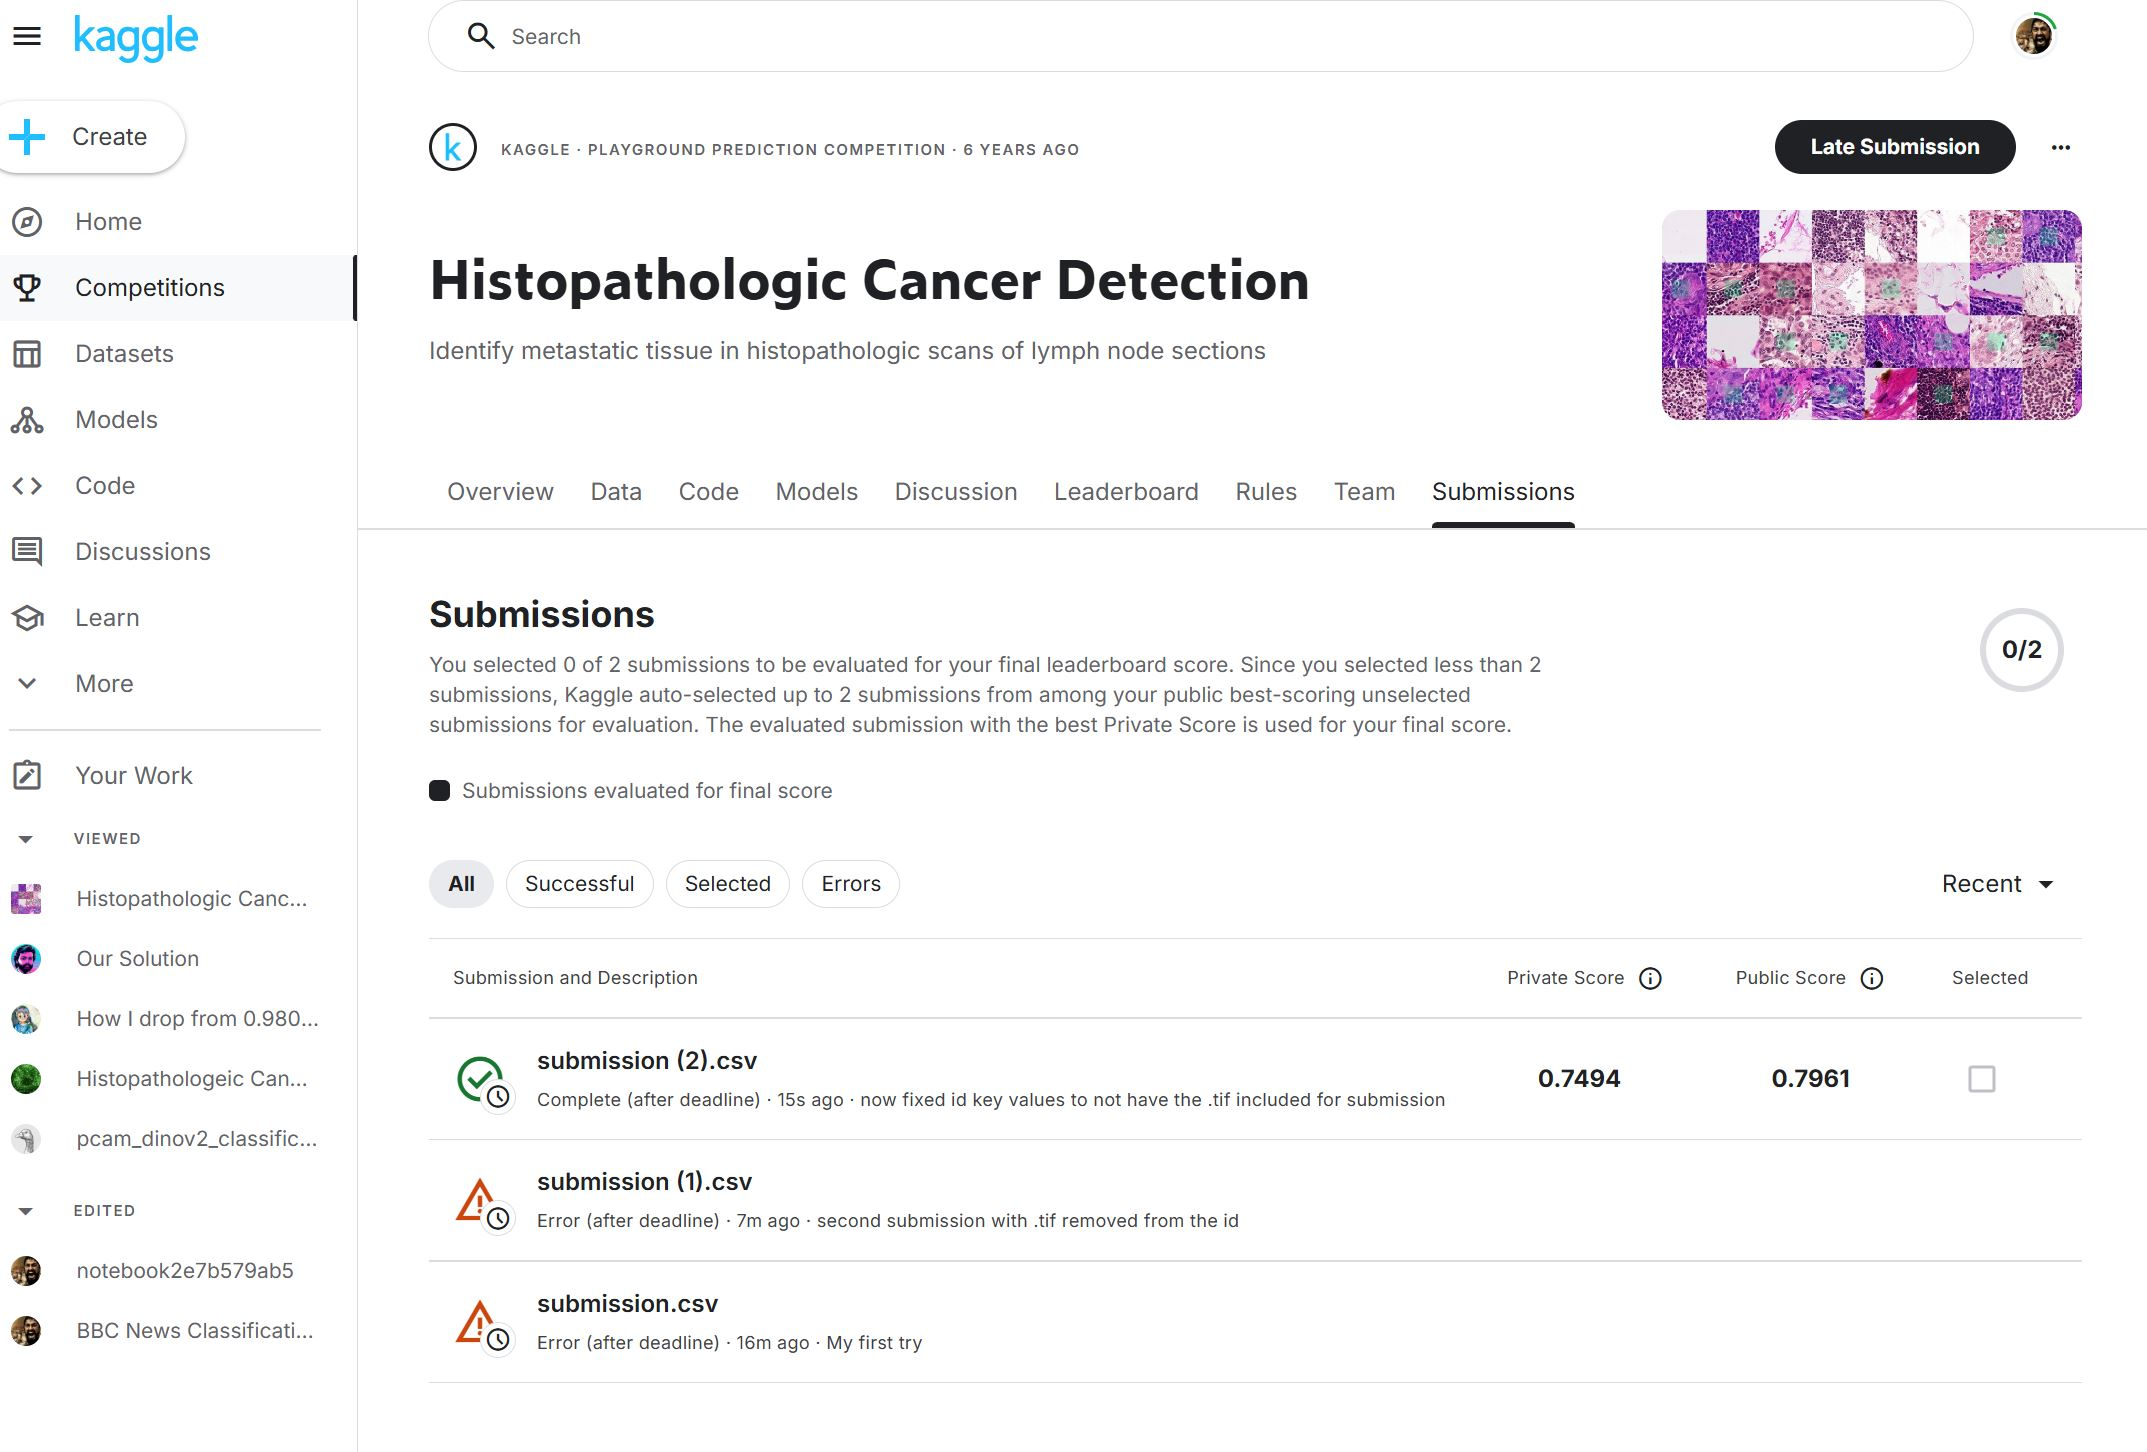

In [41]:
from IPython.display import Image, display

img_path = '/content/drive/MyDrive/Colab Notebooks/CancerDetection/kaggleSubmissionResults.JPG'
display(Image(filename=img_path, width=800))


---

## Step 4: Conclusion

This project aimed to train a convolutional neural network (CNN) to classify histopathologic image patches as tumor or non-tumor, contributing to more efficient cancer screening methods. Through extensive experimentation with model architecture and regularization techniques, we identified the combination of average pooling, L2 regularization (λ = 0.0001), and dropout (rate = 0.5) as the most effective setup.

### Key Results
The best-performing configuration achieved a validation accuracy of 84.8%, and a Kaggle public leaderboard score of 0.7961 with a private score of 0.7494. This indicates strong generalization to unseen data. Notably, the model leveraged average pooling to retain distributed texture features — a better fit for the subtle patterns in medical imaging — while balancing overfitting through tuned regularization.

### What Worked
- Average Pooling outperformed MaxPooling by preserving broader contextual information, which is essential for histopathologic structures that are often diffuse rather than sharply localized.

- L2 Regularization (λ = 0.0001) struck the right balance between flexibility and constraint. Higher values (0.001, 0.01) suppressed learning too aggressively, leading to underfitting.

- Dropout at 0.5 proved optimal, effectively reducing overfitting without impairing learning capacity. Lower (0.3) and higher (0.7) rates led to under- or over-regularization.

- Early Stopping based on validation loss helped avoid unnecessary epochs and preserved the best-performing model weights.

### What Did Not Help
- MaxPooling, while effective in other domains, underperformed in this case — likely because it emphasized the strongest activations at the expense of subtler, distributed tumor features.

- Higher L2 values (≥ 0.001) consistently hurt performance, indicating that aggressive weight penalization constrained the model’s ability to learn detailed features.

- Model Ensembling of similar architectures provided no gain and, in fact, led to lower validation accuracy (~51.7%). The lack of diversity between ensemble members likely limited the ensemble’s effectiveness.

### Future Work
To further improve performance and robustness, the following strategies could be explored:

- Data Augmentation to synthetically expand the training set using flips, rotations, and brightness variation — increasing the model’s ability to generalize.

- Focal Loss or Weighted Binary Crossentropy to address the mild class imbalance and improve recall on tumor images.

- Pretrained Architectures (e.g., EfficientNet, ResNet) fine-tuned on this dataset could yield better representations with fewer parameters.

- ROI-Based Aggregation: Grouping predictions across spatially neighboring patches could offer a more realistic view of metastasis presence at a regional level.

### Final Takeaway
The most effective model was not the deepest or most complex — but the most well-regularized. A moderate CNN with average pooling, L2 = 0.0001, and dropout = 0.5 achieved the best validation accuracy and generalization on Kaggle. This highlights the value of thoughtful tuning over brute complexity — particularly in medical imaging tasks where interpretability and stability are as important as raw accuracy.

---

---
end
---